In [47]:
# импортирт основных библиотек, зафиксировал seed и проверил версии
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

import sklearn, matplotlib, seaborn


In [48]:
# чтение
CLF_PATH = "Restaurant_Reviews.csv"
REG_PATH = "NY Realstate Pricing.csv"

clf_df = pd.read_csv(CLF_PATH, sep='\t')
reg_df = pd.read_csv(REG_PATH)

clf_df rows,cols: (1000, 2)
reg_df rows,cols: (17614, 12)


Liked
1    500
0    500
Name: count, dtype: int64

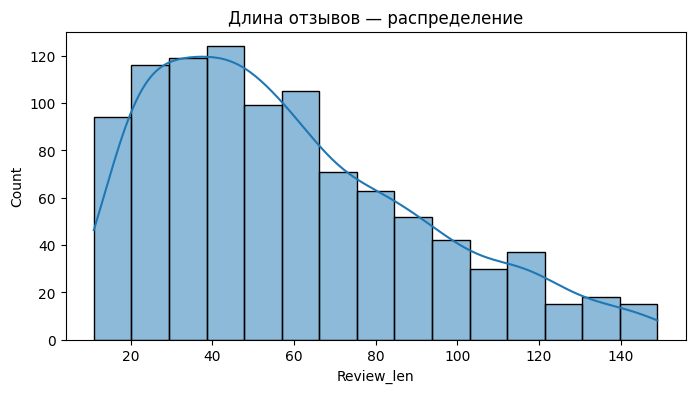

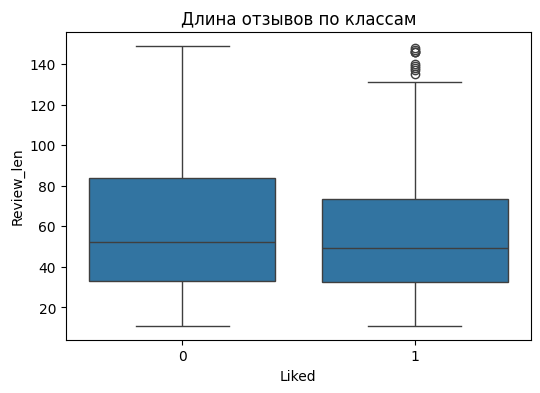

Числовые колонки reg_df: ['F1', 'id', 'latitude', 'longitude', 'price', 'days_occupied_in_2019', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'availability_2020']


,count,mean,std,min,25%,50%,75%,max
F1,17614.0,1.854756e+04,1.100072e+04,0.00000,8.192250e+03,1.949650e+04,2.868675e+04,3.559600e+04
id,17614.0,1.572032e+07,9.644155e+06,2595.00000,6.718288e+06,1.654699e+07,2.407707e+07,3.056528e+07
latitude,17614.0,4.072675e+01,5.698110e-02,40.50868,4.068604e+01,4.072054e+01,4.076313e+01,4.090804e+01
longitude,17614.0,-7.394773e+01,5.021280e-02,-74.23986,-7.398094e+01,-7.395305e+01,-7.393068e+01,-7.372179e+01
price,17614.0,1.454555e+02,1.949907e+02,0.00000,7.000000e+01,1.090000e+02,1.700000e+02,9.999000e+03
days_occupied_in_2019,17614.0,1.795177e+02,1.302020e+02,0.00000,3.500000e+01,1.980000e+02,3.010000e+02,3.640000e+02
minimum_nights,17614.0,7.392926e+00,1.923387e+01,1.00000,2.000000e+00,3.000000e+00,5.000000e+00,1.125000e+03
number_of_reviews,17614.0,5.612899e+01,6.597237e+01,1.00000,9.000000e+00,3.300000e+01,7.900000e+01,6.750000e+02
reviews_per_month,17614.0,1.607060e+00,1.635528e+00,0.01000,3.400000e-01,1.060000e+00,2.460000e+00,1.925000e+01
availability_2020,17614.0,1.541548e+02,1.380797e+02,0.00000,8.000000e+00,1.250000e+02,3.090000e+02,3.650000e+02


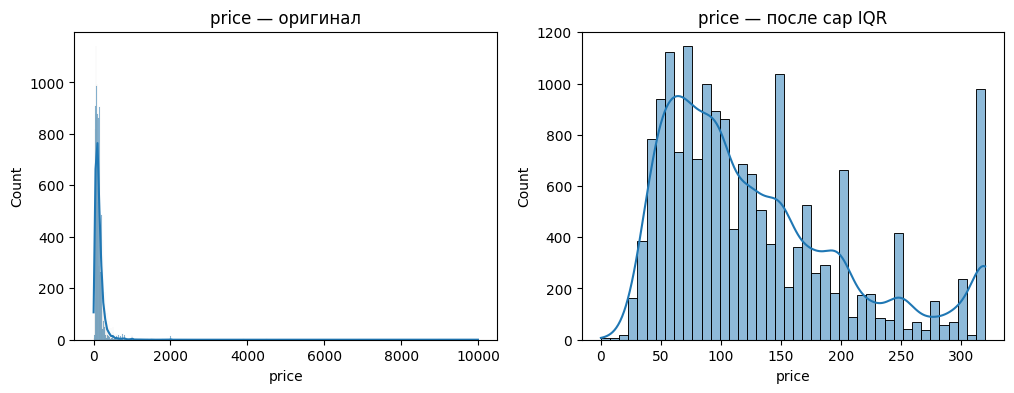

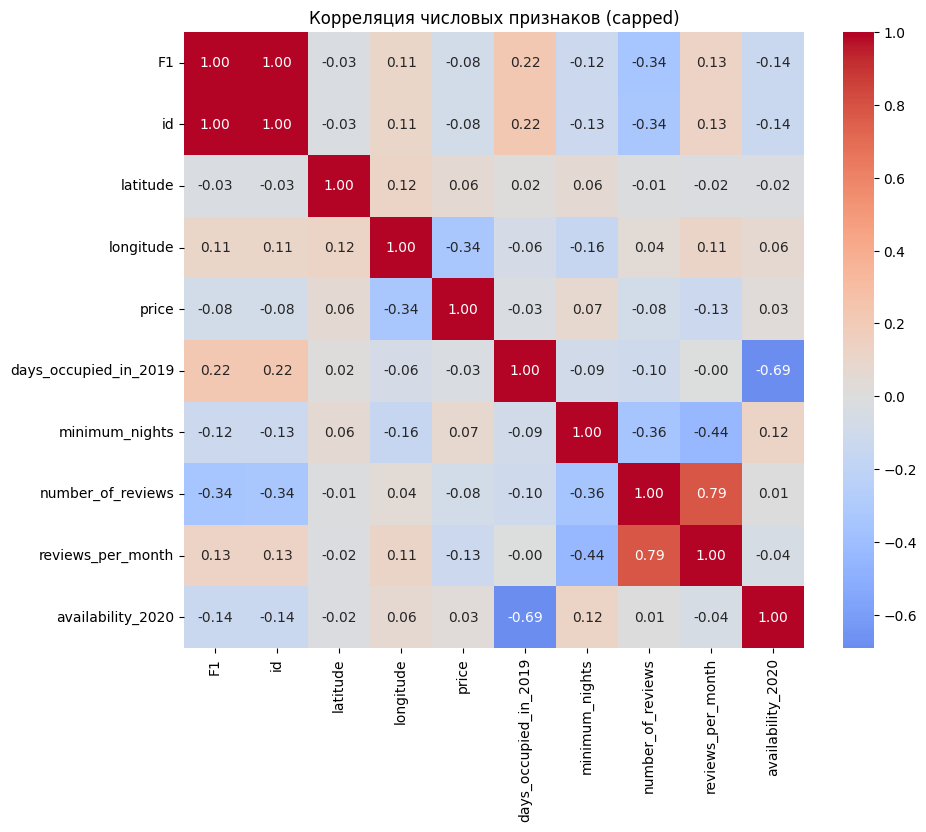

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

print("clf_df rows,cols:", getattr(clf_df, "shape", None))
print("reg_df rows,cols:", getattr(reg_df, "shape", None))

if 'Liked' in clf_df.columns:
    display(clf_df['Liked'].value_counts())

if 'Review_len' not in clf_df.columns and 'Review' in clf_df.columns:
    clf_df['Review_len'] = clf_df['Review'].astype(str).map(len)

if 'Review_len' in clf_df.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(clf_df['Review_len'].dropna(), kde=True)
    plt.title('Длина отзывов — распределение')
    plt.show()

    plt.figure(figsize=(6,4))
    sns.boxplot(x='Liked', y='Review_len', data=clf_df)
    plt.title('Длина отзывов по классам')
    plt.show()

num_cols = reg_df.select_dtypes(include=[np.number]).columns.tolist()
print("Числовые колонки reg_df:", num_cols)
display(reg_df[num_cols].describe().T)

def cap_iqr(df, cols):
    df = df.copy()
    for c in cols:
        Q1 = df[c].quantile(0.25)
        Q3 = df[c].quantile(0.75)
        IQR = Q3 - Q1
        low = Q1 - 1.5 * IQR
        high = Q3 + 1.5 * IQR
        df[c] = df[c].clip(lower=low, upper=high)
    return df

reg_df_capped = cap_iqr(reg_df, num_cols)

if 'price' in num_cols:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.histplot(reg_df['price'].dropna(), kde=True)
    plt.title('price — оригинал')
    plt.subplot(1,2,2)
    sns.histplot(reg_df_capped['price'].dropna(), kde=True)
    plt.title('price — после cap IQR')
    plt.show()

if len(num_cols) > 1:
    corr = reg_df_capped[num_cols].corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
    plt.title('Корреляция числовых признаков (capped)')
    plt.show()

In [50]:
# просмотр классификации
clf_df.head()
clf_df.info()
clf_df.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Review      1000 non-null   object
 1   Liked       1000 non-null   int64 
 2   Review_len  1000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 23.6+ KB


,Review,Liked,Review_len
count,1000,1000.00000,1000.000000
unique,996,NaN,NaN
top,I won't be back.,NaN,NaN
freq,2,NaN,NaN
mean,NaN,0.50000,58.315000
std,NaN,0.50025,32.360052
min,NaN,0.00000,11.000000
25%,NaN,0.00000,33.000000
50%,NaN,0.50000,51.000000
75%,NaN,1.00000,80.000000


In [51]:
reg_df.head()

,F1,id,neighbourhood,latitude,longitude,room_type,price,days_occupied_in_2019,minimum_nights,number_of_reviews,reviews_per_month,availability_2020
0,0,2595,Midtown,40.75362,-73.98377,Entire home/apt,225,15,10,48,0.39,1
1,1,3831,Brooklyn,40.68514,-73.95976,Entire home/apt,89,188,1,295,4.67,1
2,2,5099,Manhattan,40.74767,-73.97500,Entire home/apt,200,362,3,78,0.60,19
3,3,5121,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,0,29,49,0.38,365
4,4,5178,Manhattan,40.76489,-73.98493,Private room,79,141,2,454,3.52,242


In [52]:
# просмотр регресии

reg_df.info()
reg_df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17614 entries, 0 to 17613
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   F1                     17614 non-null  int64  
 1   id                     17614 non-null  int64  
 2   neighbourhood          17614 non-null  object 
 3   latitude               17614 non-null  float64
 4   longitude              17614 non-null  float64
 5   room_type              17614 non-null  object 
 6   price                  17614 non-null  int64  
 7   days_occupied_in_2019  17614 non-null  int64  
 8   minimum_nights         17614 non-null  int64  
 9   number_of_reviews      17614 non-null  int64  
 10  reviews_per_month      17614 non-null  float64
 11  availability_2020      17614 non-null  int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 1.6+ MB


,F1,id,latitude,longitude,price,days_occupied_in_2019,minimum_nights,number_of_reviews,reviews_per_month,availability_2020
count,17614.000000,1.761400e+04,17614.000000,17614.000000,17614.000000,17614.000000,17614.000000,17614.000000,17614.000000,17614.000000
mean,18547.564664,1.572032e+07,40.726755,-73.947732,145.455490,179.517656,7.392926,56.128988,1.607060,154.154763
std,11000.717341,9.644155e+06,0.056981,0.050213,194.990677,130.202015,19.233869,65.972370,1.635528,138.079651
min,0.000000,2.595000e+03,40.508680,-74.239860,0.000000,0.000000,1.000000,1.000000,0.010000,0.000000
25%,8192.250000,6.718288e+06,40.686042,-73.980938,70.000000,35.000000,2.000000,9.000000,0.340000,8.000000
50%,19496.500000,1.654699e+07,40.720540,-73.953050,109.000000,198.000000,3.000000,33.000000,1.060000,125.000000
75%,28686.750000,2.407707e+07,40.763127,-73.930682,170.000000,301.000000,5.000000,79.000000,2.460000,309.000000
max,35596.000000,3.056528e+07,40.908040,-73.721790,9999.000000,364.000000,1125.000000,675.000000,19.250000,365.000000


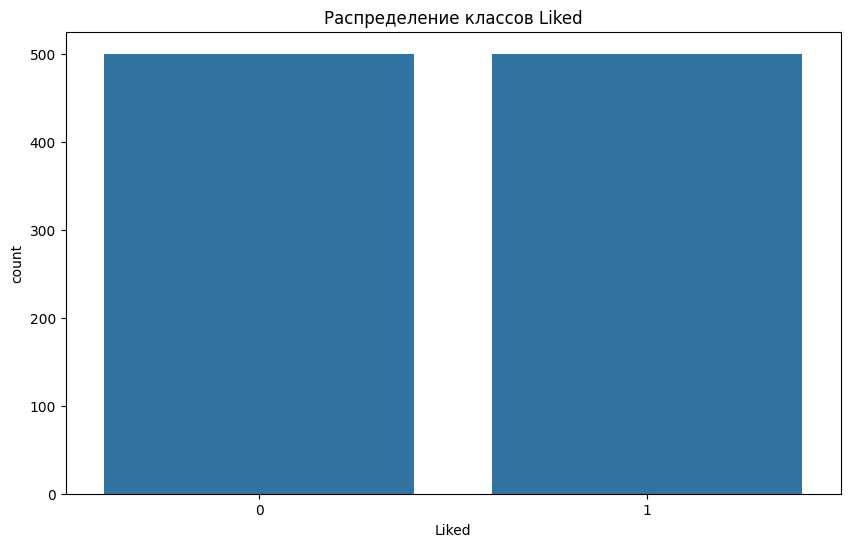

In [53]:
sns.countplot(x="Liked", data=clf_df)
plt.title("Распределение классов Liked")
plt.show()

In [54]:
print(reg_df.columns)


Index(['F1', 'id', 'neighbourhood', 'latitude', 'longitude', 'room_type',
       'price', 'days_occupied_in_2019', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'availability_2020'],
      dtype='object')


In [55]:
# подготавливаем данные

from sklearn.feature_extraction.text import TfidfVectorizer

X_clf = clf_df['Review'].values
y_clf = clf_df['Liked'].values

vectorizer = TfidfVectorizer(max_features=3000)
X_clf = vectorizer.fit_transform(X_clf)

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)


In [56]:
# подготовка данных для регрессии

target_column = "price"

num_cols = reg_df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove(target_column)

X_reg = reg_df[num_cols].fillna(reg_df[num_cols].median())
y_reg = reg_df[target_column]

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

In [57]:
# подготовка пайплайна, RandomizedSearchCV и оценка
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import category_encoders as ce

num_feats = X_train_reg.select_dtypes(include=[np.number]).columns.tolist()
cat_feats = X_train_reg.select_dtypes(exclude=[np.number]).columns.tolist()

num_pipe = Pipeline([('scaler', StandardScaler())])
cat_pipe = Pipeline([('tgt', ce.TargetEncoder())])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_feats),
    ('cat', cat_pipe, cat_feats)
])

model = RandomForestRegressor(random_state=RANDOM_STATE)
pipe = Pipeline([('pre', preprocessor), ('model', model)])

param_dist = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10]
}

rs = RandomizedSearchCV(pipe, param_dist, n_iter=12, cv=3, scoring='r2',
                        random_state=RANDOM_STATE, n_jobs=-1, verbose=1)
rs.fit(X_train_reg, y_train_reg)

print('Best params:', rs.best_params_)
print('Train best score (cv):', rs.best_score_)
print('Test R2:', rs.score(X_test_reg, y_test_reg))

from sklearn.metrics import mean_absolute_error, mean_squared_error
y_pred = rs.predict(X_test_reg)
print('MAE:', mean_absolute_error(y_test_reg, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test_reg, y_pred)))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'model__n_estimators': 100, 'model__min_samples_split': 10, 'model__max_depth': 20}
Train best score (cv): 0.10552335510537054
Test R2: 0.09779202561115485
MAE: 69.09830231149638
RMSE: 170.31479917003347


In [58]:
# функции оценки качества

def eval_clf(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average="macro"),
        "recall": recall_score(y_true, y_pred, average="macro"),
        "f1_macro": f1_score(y_true, y_pred, average="macro")
    }

def eval_reg(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred)
    }


In [59]:
# обучение и оценка базовой модели

knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train_clf, y_train_clf)

y_pred_clf = knn_clf.predict(X_test_clf)

print(eval_clf(y_test_clf, y_pred_clf))


{'accuracy': 0.73, 'precision': 0.7309253246753247, 'recall': 0.7279647435897436, 'f1_macro': 0.7282608695652174}


In [60]:
# обучение и оценка

scaler = StandardScaler()
X_train_reg_scaled = scaler.fit_transform(X_train_reg)
X_test_reg_scaled = scaler.transform(X_test_reg)

knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train_reg_scaled, y_train_reg)

y_pred_reg = knn_reg.predict(X_test_reg_scaled)

print(eval_reg(y_test_reg, y_pred_reg))


{'MAE': 77.02673857507806, 'MSE': 34863.53664490491, 'RMSE': np.float64(186.71779948602895), 'R2': -0.08435960025128053}


In [61]:
# подбор гиперпараметра классификация

params = {"n_neighbors": [3, 5, 7, 9]}

gs_clf = GridSearchCV(
    KNeighborsClassifier(),
    params,
    cv=3,
    scoring="f1_macro"
)

gs_clf.fit(X_train_clf, y_train_clf)

print(gs_clf.best_params_)


{'n_neighbors': 7}


In [62]:
# подбор гиперпараметра регрессия

params = {"n_neighbors": [3, 5, 7, 9]}

gs_reg = GridSearchCV(
    KNeighborsRegressor(),
    params,
    cv=3,
    scoring="r2"
)

gs_reg.fit(X_train_reg_scaled, y_train_reg)

print(gs_reg.best_params_)


{'n_neighbors': 9}


In [63]:
# моя реализация KNN классификатора

from sklearn.base import BaseEstimator, ClassifierMixin

class SKMyKNNCls(BaseEstimator, ClassifierMixin):
    def __init__(self, k=5, weights='uniform', metric='euclidean', n_jobs=1):
        self.k = int(k)
        self.weights = weights
        self.metric = metric
        self.n_jobs = n_jobs

    def fit(self, X, y):
        X, y = check_X_y(X, y, accept_sparse=True)
        self.X_train_ = X
        self.y_train_ = np.asarray(y)
        return self

    def predict(self, X):
        X = check_array(X, accept_sparse=True)
        dists = pairwise_distances(X, self.X_train_, metric=self.metric, n_jobs=self.n_jobs)
        k = min(self.k, self.X_train_.shape[0])
        idx_part = np.argpartition(dists, kth=k-1, axis=1)[:, :k]
        rows = np.arange(dists.shape[0])[:, None]
        neigh_dists = dists[rows, idx_part]
        neigh_idx = idx_part
        neigh_vals = self.y_train_[neigh_idx]
        if self.weights == 'uniform':
            preds = np.mean(neigh_vals, axis=1)
        elif self.weights == 'distance':
            eps = 1e-8
            w = 1.0 / (neigh_dists + eps)
            w_sum = np.sum(w, axis=1, keepdims=True)
            w_norm = w / w_sum
            preds = np.sum(neigh_vals * w_norm, axis=1)
        else:
            raise ValueError("weights must be 'uniform' or 'distance'")
        if np.array_equal(np.unique(self.y_train_), [0,1]) or np.issubdtype(self.y_train_.dtype, np.integer):
            return np.rint(preds).astype(int)
        else:
            from scipy.stats import mode
            mode_vals, _ = mode(neigh_vals, axis=1)
            return mode_vals.ravel().astype(self.y_train_.dtype)


In [64]:
# тест моей реализации

pipe_my_clf = Pipeline([('model', SKMyKNNCls(k=5))])
pipe_my_clf.fit(X_train_clf, y_train_clf)
y_pred_my = pipe_my_clf.predict(X_test_clf)
print(eval_clf(y_test_clf, y_pred_my))



{'accuracy': 0.73, 'precision': 0.7309253246753247, 'recall': 0.7279647435897436, 'f1_macro': 0.7282608695652174}


In [65]:
# сравнение моделей
rows = []
rows.append(["KNN baseline", eval_clf(y_test_clf, y_pred_clf)["f1_macro"]])
rows.append(["MyKNN", eval_clf(y_test_clf, y_pred_my)["f1_macro"]])

df_compare = pd.DataFrame(rows, columns=["Модель", "F1 Macro"])
df_compare

,Модель,F1 Macro
0,KNN baseline,0.728261
1,MyKNN,0.728261
